# Correlation analysis
Explore the relationships between core and accessory genes

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from textwrap import fill
from core_acc_modules import utils, paths

np.random.seed(123)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in data (grouped by reference used)
gene_expression_ref_pao1 = pd.read_csv(paths.PAO1_GE, sep="\t", header=0, index_col=0)
gene_expression_ref_pa14 = pd.read_csv(paths.PA14_GE, sep="\t", header=0, index_col=0)

In [3]:
print(gene_expression_ref_pao1.shape)
print(gene_expression_ref_pa14.shape)

(28, 5685)
(28, 5959)


## Get shuffled dataset
The shuffled gene expression data is generated by starting with the real gene expression data. For each sample, gene values within a given sample are shuffled independently in order to disrupt any existing relationship between genes. This will serve as a negative control when examining the relationship between genes later.

In [4]:
# Shuffled gene expression datasets
shuffled_all_ref_pao1 = utils.permute_expression_data(gene_expression_ref_pao1)
shuffled_all_ref_pa14 = utils.permute_expression_data(gene_expression_ref_pa14)

## Get gene mapping

In [5]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pao1')
gene_mapping_pao1.head()

,Name,Product.Name,GeneID.(PAO1),PA14_ID,annotation,num_mapped_genes
PAO1_ID,,,,,,
PA0001,dnaA,chromosomal replication initiator protein DnaA,878417.0,PA14_00010,core,1.0
PA0002,dnaN,"DNA polymerase III, beta chain",879244.0,PA14_00020,core,1.0
PA0003,recF,RecF protein,879229.0,PA14_00030,core,1.0
PA0004,gyrB,DNA gyrase subunit B,879230.0,PA14_00050,core,1.0
PA0005,lptA,"lysophosphatidic acid acyltransferase, LptA",877576.0,PA14_00060,core,1.0


In [6]:
# Get mapping between PAO1 and PA14 genes using PA14 reference
gene_annot_file = paths.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pa14')
gene_mapping_pa14.head()

,Name,Product.Name,GeneID.(PAO1),PAO1_ID,annotation,num_mapped_genes
PA14_ID,,,,,,
PA14_00010,dnaA,chromosomal replication initiation protein,878417.0,PA0001,core,1.0
PA14_00020,dnaN,DNA polymerase III subunit beta,879244.0,PA0002,core,1.0
PA14_00030,recF,recombination protein F,879229.0,PA0003,core,1.0
PA14_00050,gyrB,DNA gyrase subunit B,879230.0,PA0004,core,1.0
PA14_00060,NaN,acyltransferase,877576.0,PA0005,core,1.0


In [7]:
# Check that the number of non-unique mapped genes is consistent with our manual findings
assert gene_mapping_pao1[gene_mapping_pao1["num_mapped_genes"] > 1].shape[0] == 5
assert gene_mapping_pa14[gene_mapping_pa14["num_mapped_genes"] > 1].shape[0] == 10

## Get core genes
Core genes homologous between PAO1 and PA14. **PAO1 core genes** are PAO1 reference genes that have a PA14 homolog found. Similarly, **PA14 core genes** are PA14 refrence genes that have a PAO1 homolog.

* PAO1 core and PA14 core mostly overlap but not completely. 
* 5355 genes overlap when compare PAO1 core genes map to PA14 ids vs PA14 core
* 5351 genes overlap when compare PA14 core genes map to PAO1 ids vs PA14 core

Here we will define **core genes** = union(PAO1 core genes, PA14 core genes)

The annotations for what genes are homoglous between PAO1 and PA14 were obtained from [BACTOME website](https://pseudomonas-annotator.shinyapps.io/pa_annotator/)

In [8]:
core_pao1_genes, core_pa14_genes = utils.get_core_genes(gene_mapping_pao1,
                                                        gene_mapping_pa14,
                                                        False)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363


In [9]:
## Check
# Using annotation files with extension _mod.tsv
#pao1_ref_core_df = gene_mapping_pao1[
#            (gene_mapping_pao1["annotation"] == "core")
#        ]
#pa14_ref_core_df = gene_mapping_pa14[
#    (gene_mapping_pa14["annotation"] == "core")
#]
#pao1_mapped_genes = pa14_ref_core_df.loc[core_pa14_genes, "PAO1_ID"]
#print(len(set(pao1_mapped_genes).intersection(core_pao1_genes)))

#pa14_mapped_genes = pao1_ref_core_df.loc[core_pao1_genes, "PA14_ID"]
#print(len(set(pa14_mapped_genes).intersection(core_pa14_genes)))

**Note:** 
I have checked that the `core_pao1_genes` completely intersects with the core genes mapped from `core_pa14_genes` and vice versa. The 3 extra genes must be due to some many to one mapping between the two strains. Based on our check we do not believe these 3 genes are due to a issue taking the union 

## Get accessory genes

**PAO1 accessory** = All PAO1 genes - core genes (PAO1-specific genes)

**PA14 accessory** = All PA14 genes - core genes (PA14-specific genes)

In [10]:
# Get PAO1-specific genes
pao1_ref_genes = gene_expression_ref_pao1.columns
pao1_acc = list(set(pao1_ref_genes) - set(core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 322


In [11]:
# Check that `get_pao1_pa14_gene_map` function is working as expected
assert("PA0053" not in core_pao1_genes and "PA0053" in pao1_acc)

In [12]:
# Get PA14-specific genes
pa14_ref_genes = gene_expression_ref_pa14.columns
pa14_acc = list(set(pa14_ref_genes) - set(core_pa14_genes))
print(f"Number of PA14-specific genes: {len(pa14_acc)}")

Number of PA14-specific genes: 597


In [13]:
# Check that `get_pao1_pa14_gene_map` function is working as expected
assert("PA14_00410" not in core_pa14_genes and "PA14_00410" in pa14_acc)

## Group samples by genotype

In [14]:
# Group samples as PAO1 or PA14 based on experiment metadata
sample_annot_file = paths.SAMPLE_ANNOT

pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [15]:
# PAO1 samples aligned to PAO1 reference
data_core_pao1_samples_pao1_ref = gene_expression_ref_pao1.reindex(index=pao1_ids, columns=core_pao1_genes)
data_acc_pao1_samples_pao1_ref = gene_expression_ref_pao1.loc[pao1_ids, pao1_acc]
print(data_core_pao1_samples_pao1_ref.shape)
print(data_acc_pao1_samples_pao1_ref.shape)

(13, 5366)
(13, 322)


In [16]:
# PA14 samples aligned to PA14 reference
data_core_pa14_samples_pa14_ref = gene_expression_ref_pa14.loc[pa14_ids, core_pa14_genes]
data_acc_pa14_samples_pa14_ref = gene_expression_ref_pa14.loc[pa14_ids, pa14_acc]
print(data_core_pa14_samples_pa14_ref.shape)
print(data_acc_pa14_samples_pa14_ref.shape)

(15, 5363)
(15, 597)


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [17]:
# PA14 samples aligned to PAO1 reference
data_core_pa14_samples_pao1_ref = gene_expression_ref_pao1.loc[pa14_ids, core_pao1_genes]
data_acc_pa14_samples_pao1_ref = gene_expression_ref_pao1.loc[pa14_ids, pao1_acc]
print(data_core_pa14_samples_pao1_ref.shape)
print(data_acc_pa14_samples_pao1_ref.shape)

(15, 5366)
(15, 322)


In [18]:
# PAO1 samples aligned to PA14 reference
data_core_pao1_samples_pa14_ref = gene_expression_ref_pa14.loc[pao1_ids, core_pa14_genes]
data_acc_pao1_samples_pa14_ref = gene_expression_ref_pa14.loc[pao1_ids, pa14_acc]
print(data_core_pao1_samples_pa14_ref.shape)
print(data_acc_pao1_samples_pa14_ref.shape)

(13, 5363)
(13, 597)


## Distribution of gene expression
Examine the distribution of mean gene expression for core and accessory genes in each of these 4 groups of samples (total of 8 plots)

In [19]:
# Examine PAO1 samples in PAO1 reference
pao1_samples_pao1_ref_core = gene_expression_ref_pao1.loc[pao1_ids,core_pao1_genes].mean()
pao1_samples_pao1_ref_acc = gene_expression_ref_pao1.loc[pao1_ids,pao1_acc].mean()

# Examine PA14 samples in PAO1 reference
pa14_samples_pao1_ref_core = gene_expression_ref_pao1.loc[pa14_ids,core_pao1_genes].mean()
pa14_samples_pao1_ref_acc = gene_expression_ref_pao1.loc[pa14_ids,pao1_acc].mean()

# Examine PAO1 samples in PA14 reference
pao1_samples_pa14_ref_core = gene_expression_ref_pa14.loc[pao1_ids,core_pa14_genes].mean()
pao1_samples_pa14_ref_acc = gene_expression_ref_pa14.loc[pao1_ids,pa14_acc].mean()

# Examine PA14 samples in PA14 reference
pa14_samples_pa14_ref_core = gene_expression_ref_pa14.loc[pa14_ids,core_pa14_genes].mean()
pa14_samples_pa14_ref_acc = gene_expression_ref_pa14.loc[pa14_ids,pa14_acc].mean()

In [20]:
# Check if any core genes have 0 expression in PAO1 samples using PAO1 reference (or PA14 samples in PA14 reference)
# We would expect core genes to have nonzero expression in these cases
# This might call for an adjustment to how we are processing the data using Salmon quant
print(any(pao1_samples_pao1_ref_core < 0))
print(any(pa14_samples_pa14_ref_core < 0))

False
False


In [21]:
# Save nonzero accessory genes in cross comparison
# These are PAO1-specific genes that are nonzero in PA14 samples
# or PA14-specific genes that are nonzero in PAO1 samples

pd.DataFrame(pao1_samples_pa14_ref_acc[pao1_samples_pa14_ref_acc>0]).to_csv(paths.PAO1_SAMPLE_PA14_REF, sep="\t")
pd.DataFrame(pa14_samples_pao1_ref_acc[pa14_samples_pao1_ref_acc>0]).to_csv(paths.PA14_SAMPLE_PAO1_REF, sep="\t")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.01, 0.5, 'Count')

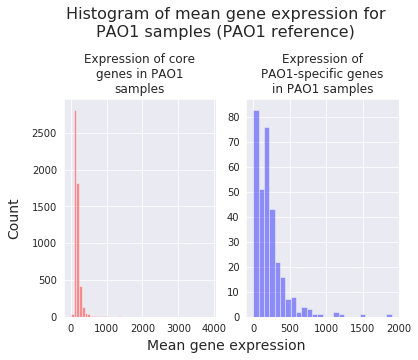

In [22]:
# Plot
sns.set_style("darkgrid")

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pao1_samples_pao1_ref_core.values, 
             label='PAO1 samples PAO1 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pao1_samples_pao1_ref_acc.values,
             label='PAO1 samples PAO1 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle(fill('Histogram of mean gene expression for PAO1 samples (PAO1 reference)', width=40),
             x=0.5,
             y=1.2,
             fontsize=16)
axes[0].set_title(fill('Expression of core genes in PAO1 samples', width=20))
axes[1].set_title(fill('Expression of PAO1-specific genes in PAO1 samples', width=20))
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)

Text(0.01, 0.5, 'Count')

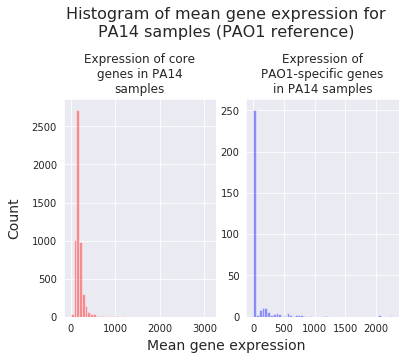

In [23]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pa14_samples_pao1_ref_core.values, 
             label='PA14 samples PAO1 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pa14_samples_pao1_ref_acc.values,
             label='PA14 samples PAO1 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle(fill('Histogram of mean gene expression for PA14 samples (PAO1 reference)', width=40),
             x=0.5,
             y=1.2,
            fontsize=16)
axes[0].set_title(fill('Expression of core genes in PA14 samples', width=20))
axes[1].set_title(fill('Expression of PAO1-specific genes in PA14 samples', width=20))
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)

Text(0.01, 0.5, 'Count')

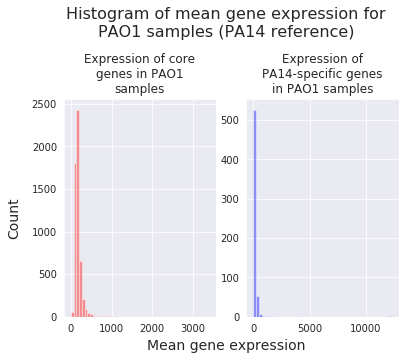

In [24]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pao1_samples_pa14_ref_core.values, 
             label='PAO1 samples PA14 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pao1_samples_pa14_ref_acc.values,
             label='PAO1 samples PA14 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle(fill('Histogram of mean gene expression for PAO1 samples (PA14 reference)', width=40),
             x=0.5,
             y=1.2,
            fontsize=16)
axes[0].set_title(fill('Expression of core genes in PAO1 samples', width=20))
axes[1].set_title(fill('Expression of PA14-specific genes in PAO1 samples', width=20))
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)

Text(0.01, 0.5, 'Count')

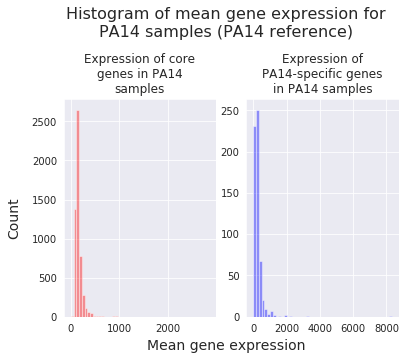

In [25]:
# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,4))

# Distribution plot for core genes
sns.distplot(pa14_samples_pa14_ref_core.values, 
             label='PA14 samples PA14 core genes', 
             color='red',
             kde=False,
             ax=axes[0]
            )

sns.distplot(pa14_samples_pa14_ref_acc.values,
             label='PA14 samples PA14 accessory genes',
             color='blue',
             kde=False,
             ax=axes[1]
            )

fig.xlim=(0,10)
plt.suptitle(fill('Histogram of mean gene expression for PA14 samples (PA14 reference)', width=40),
             x=0.5,
             y=1.2,
            fontsize=16)
axes[0].set_title(fill('Expression of core genes in PA14 samples', width=20))
axes[1].set_title(fill('Expression of PA14-specific genes in PA14 samples', width=20))
fig.text(0.5, 0.01, 'Mean gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)

**Takeaway:**
* PAO1-specific genes have mainly 0 mean gene expression in PA14 samples, as expected. A similar trend is seen in PA14-specific genes in PAO1 samples.
* In general, many accessory genes are 0 expressed in cases where the samples and reference match (i.e. PA14 samples in PA14 reference or PAO1 samples in PAO1 reference). This is consistent with the hypothesis that accessory genes are context specific and so perhaps in this experiment, these accessory genes are not expressed.
* There are a small number of PAO1-specific genes that have nonzero expression in PA14 samples. What are these nonzero accessory genes? Genes with some low level homology? Something else to be discussed with collaborators.

## Correlation analysis
PAO1 samples using PAO1 reference:
* **corr**(core, PAO1 core)
* **corr**(core, PAO1 accessory)
* **corr**(PAO1 accessory, PAO1 accessory) 

PA14 samples using PA14 reference:
* **corr**(core, PA14 core)
* **corr**(core, PA14 accessory)
* **corr**(PA14 accessory, PA14 accessory)

cross-correlation analysis:

PA14 samples using PAO1 reference:
* **corr**(core, PAO1 core)
* **corr**(core, PAO1 accessory)
* **corr**(PAO1 accessory, PAO1 accessory) 

PAO1 samples using PA14 reference:
* **corr**(core, PA14 core)
* **corr**(core, PA14 accessory)
* **corr**(PA14 accessory, PA14 accessory)

In [26]:
# Get correlation of core-core genes
pao1_core_corr = data_core_pao1_samples_pao1_ref.corr(method='pearson')
pao1_core_corr = pao1_core_corr.values[np.triu_indices(n=len(pao1_core_corr), k=1)]

pa14_core_corr = data_core_pa14_samples_pa14_ref.corr(method='pearson')
pa14_core_corr = pa14_core_corr.values[np.triu_indices(n=len(pa14_core_corr), k=1)]

pa14_samples_pao1_core_corr = data_core_pa14_samples_pao1_ref.corr(method='pearson')
pa14_samples_pao1_core_corr = pa14_samples_pao1_core_corr.values[
    np.triu_indices(n=len(pa14_samples_pao1_core_corr), k=1)]

pao1_samples_pa14_core_corr = data_core_pao1_samples_pa14_ref.corr(method='pearson')
pao1_samples_pa14_core_corr = pao1_samples_pa14_core_corr.values[
    np.triu_indices(n=len(pao1_samples_pa14_core_corr), k=1)]

In [27]:
# Get correlation of accessory-accessory genes
pao1_acc_corr = data_acc_pao1_samples_pao1_ref.corr(method='pearson')
pao1_acc_corr = pao1_acc_corr.values[np.triu_indices(n=len(pao1_acc_corr), k=1)]

pa14_acc_corr = data_acc_pa14_samples_pa14_ref.corr(method='pearson')
pa14_acc_corr = pa14_acc_corr.values[np.triu_indices(n=len(pa14_acc_corr), k=1)]

pa14_samples_pao1_acc_corr = data_acc_pa14_samples_pao1_ref.corr(method='pearson')
pa14_samples_pao1_acc_corr = pa14_samples_pao1_acc_corr.values[
    np.triu_indices(n=len(pa14_samples_pao1_acc_corr), k=1)]

pao1_samples_pa14_acc_corr = data_acc_pao1_samples_pa14_ref.corr(method='pearson')
pao1_samples_pa14_acc_corr = pao1_samples_pa14_acc_corr.values[
    np.triu_indices(n=len(pao1_samples_pa14_acc_corr), k=1)]

In [28]:
# Get correlation of core-accessory genes
pao1_all_corr = gene_expression_ref_pao1.loc[pao1_ids].corr(method='pearson')
pa14_all_corr = gene_expression_ref_pa14.loc[pa14_ids].corr(method='pearson')

pao1_core_acc_corr = pao1_all_corr.loc[core_pao1_genes, pao1_acc]
pao1_core_acc_corr = pao1_core_acc_corr.values.flatten().tolist()

pa14_core_acc_corr = pa14_all_corr.loc[core_pa14_genes, pa14_acc]
pa14_core_acc_corr = pa14_core_acc_corr.values.flatten().tolist()

pa14_samples_pao1_all_corr = gene_expression_ref_pao1.loc[pa14_ids].corr(method='pearson')
pa14_samples_pao1_core_acc_corr = pa14_samples_pao1_all_corr.loc[core_pao1_genes, pao1_acc]
pa14_samples_pao1_core_acc_corr = pa14_samples_pao1_core_acc_corr.values.flatten().tolist()

pao1_samples_pa14_all_corr = gene_expression_ref_pa14.loc[pao1_ids].corr(method='pearson')
pao1_samples_pa14_core_acc_corr = pao1_samples_pa14_all_corr.loc[core_pa14_genes, pa14_acc]
pao1_samples_pa14_core_acc_corr = pao1_samples_pa14_core_acc_corr.values.flatten().tolist()

In [29]:
# Get correlation of control dataset
shuffled_pao1_ref_pao1_corr = shuffled_all_ref_pao1.loc[pao1_ids].corr(method='pearson')
shuffled_pao1_ref_pao1_corr = shuffled_pao1_ref_pao1_corr.values[
    np.triu_indices(n=len(shuffled_pao1_ref_pao1_corr), k=1)]

shuffled_pa14_ref_pa14_corr = shuffled_all_ref_pa14.loc[pa14_ids].corr(method='pearson')
shuffled_pa14_ref_pa14_corr = shuffled_pa14_ref_pa14_corr.values[
    np.triu_indices(n=len(shuffled_pa14_ref_pa14_corr), k=1)]

shuffled_pa14_ref_pao1_corr = shuffled_all_ref_pao1.loc[pa14_ids].corr(method='pearson')
shuffled_pa14_ref_pao1_corr = shuffled_pa14_ref_pao1_corr.values[
    np.triu_indices(n=len(shuffled_pa14_ref_pao1_corr), k=1)]

shuffled_pao1_ref_pa14_corr = shuffled_all_ref_pa14.loc[pao1_ids].corr(method='pearson')
shuffled_pao1_ref_pa14_corr = shuffled_pao1_ref_pa14_corr.values[
    np.triu_indices(n=len(shuffled_pao1_ref_pa14_corr), k=1)]

Text(0, 0.5, 'Density')

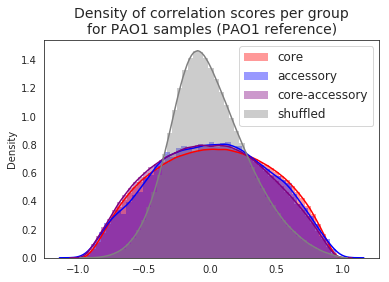

In [30]:
sns.set_style("white")

sns.distplot(pao1_core_corr, label='core', color='red', hist_kws={"linewidth": 0})
sns.distplot(pao1_acc_corr, label='accessory', color='blue', hist_kws={"linewidth": 0})
sns.distplot(pao1_core_acc_corr, label='core-accessory', color='purple', hist_kws={"linewidth": 0})
sns.distplot(shuffled_pao1_ref_pao1_corr, label='shuffled', color='grey', hist_kws={"linewidth": 0})

plt.legend(prop={'size': 12})
plt.title(fill('Density of correlation scores per group for PAO1 samples (PAO1 reference)', width=40),
         fontsize=14)
plt.ylabel('Density')

Text(0, 0.5, 'Density')

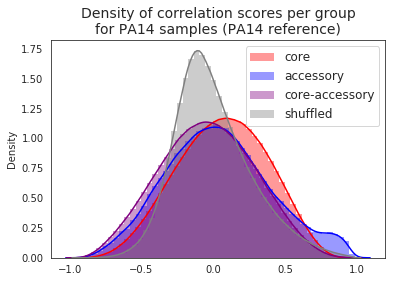

In [31]:
sns.distplot(pa14_core_corr, label='core', color='red', hist_kws={"linewidth": 0})
sns.distplot(pa14_acc_corr, label='accessory', color='blue', hist_kws={"linewidth": 0})
sns.distplot(pa14_core_acc_corr, label='core-accessory', color='purple', hist_kws={"linewidth": 0})
sns.distplot(shuffled_pa14_ref_pa14_corr, label='shuffled', color='grey', hist_kws={"linewidth": 0})

plt.legend(prop={'size': 12})
plt.title(fill('Density of correlation scores per group for PA14 samples (PA14 reference)', width=40),
          fontsize=14)
plt.ylabel('Density')

Text(0, 0.5, 'Density')

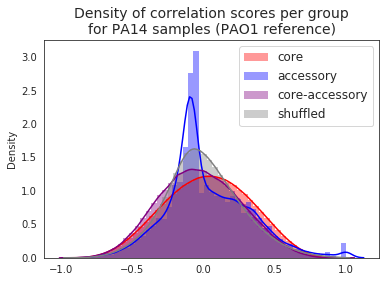

In [32]:
sns.distplot(pa14_samples_pao1_core_corr, label='core', color='red', hist_kws={"linewidth": 0})
sns.distplot(pa14_samples_pao1_acc_corr, label='accessory', color='blue', hist_kws={"linewidth": 0})
sns.distplot(pa14_samples_pao1_core_acc_corr, label='core-accessory', color='purple', hist_kws={"linewidth": 0})
sns.distplot(shuffled_pa14_ref_pao1_corr, label='shuffled', color='grey', hist_kws={"linewidth": 0})

plt.legend(prop={'size': 12})
plt.title(fill('Density of correlation scores per group for PA14 samples (PAO1 reference)', width=40),
          fontsize=14)
plt.ylabel('Density')

Text(0, 0.5, 'Density')

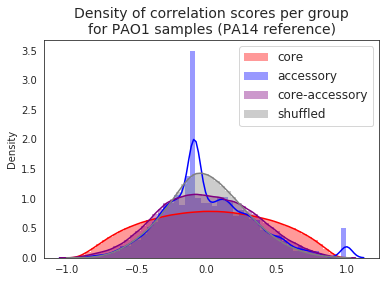

In [33]:
sns.distplot(pao1_samples_pa14_core_corr, label='core', color='red', hist_kws={"linewidth": 0})
sns.distplot(pao1_samples_pa14_acc_corr, label='accessory', color='blue', hist_kws={"linewidth": 0})
sns.distplot(pao1_samples_pa14_core_acc_corr, label='core-accessory', color='purple', hist_kws={"linewidth": 0})
sns.distplot(shuffled_pao1_ref_pa14_corr, label='shuffled', color='grey', hist_kws={"linewidth": 0})

plt.legend(prop={'size': 12})
plt.title(fill('Density of correlation scores per group for PAO1 samples (PA14 reference)', width=40),
          fontsize=14)
plt.ylabel('Density')

**Takeaway:**
* For PAO1 samples using PAO1 reference there does not seem to be a significant skewing the correlation between core-core, core-accessory or accessory-accessory
* For PA14 samples using PA14 reference there is a very slight bump in the accessory-accessory genes. We can try to look into what these genes are. But why was this trend not found in PAO1 samples using PAO1 reference?
* For PAO1 samples using PA14 reference and PA14 samples using PAO1 reference, there is the same slight bump. In general, we'd expect most accessory genes to be 0 expressed, is this the reason for the bump? 

### What are the accessory genes with high correlation?
There is a bump in the correlation between accessory-accessory genes using PA14 samples in PA14 reference, PAO1 samples in PA14 reference, and PA14 samples in PAO1 reference. We want to explore what these genes are and if their high correlation is due to having a 0 mean expression.


According to the above distribution plots, there are PAO1 accessory genes that are highly correlated in PA14 samples. There are also PA14 accessory genes that are high correlated in PAO1 and PA14 samples. We'd expect that the highly correlated PAO1 genes in PA14 samples (and PA14 genes in PAO1 samples) have a high correlation due to mean 0 expression. But we hope there is some biology behind the highly correlated PA14 genes in PA14 samples.

In [34]:
# PA14 accessory genes in PA14 samples
pa14_acc_corr = data_acc_pa14_samples_pa14_ref.corr(method='pearson')

# Reshape correlation data
pa14_acc_corr = pa14_acc_corr.where(np.triu(np.ones(pa14_acc_corr.shape), k=1).astype(np.bool))
pa14_acc_corr_df = pa14_acc_corr.stack().reset_index()
pa14_acc_corr_df.columns = ['in gene','out gene','corr score']

# Select those genes in the "bump"
selected_pa14_genes = pa14_acc_corr_df[pa14_acc_corr_df['corr score']>0.75]
print(selected_pa14_genes.shape)
selected_pa14_genes.head()

# Save genes to review with collaborators
selected_pa14_genes.to_csv(paths.HIGH_PA14_SAMPLE_PA14_REF, sep="\t")

(5476, 3)


In [35]:
# Are the accessory genes with high correlation those with 0 expression?
high_corr_genes = np.concatenate((selected_pa14_genes['in gene'].values, 
                                 selected_pa14_genes['out gene'].values)
                                )
any(pa14_samples_pa14_ref_acc[high_corr_genes] <1.0)

False

In [36]:
# PA14 accessory genes in PAO1 samples
pa14_acc_pao1_samples_corr = data_acc_pao1_samples_pa14_ref.corr(method='pearson')

# Reshape correlation data
pa14_acc_pao1_samples_corr = pa14_acc_pao1_samples_corr.where(
    np.triu(np.ones(pa14_acc_pao1_samples_corr.shape), k=1).astype(np.bool))
pa14_acc_pao1_samples_corr_df = pa14_acc_pao1_samples_corr.stack().reset_index()
pa14_acc_pao1_samples_corr_df.columns = ['in gene','out gene','corr score']

# Select those genes in the "bump"
selected_pa14_pao1_samples_genes = pa14_acc_pao1_samples_corr_df[pa14_acc_pao1_samples_corr_df['corr score']>0.75]
print(selected_pa14_pao1_samples_genes.shape)
selected_pa14_pao1_samples_genes.head()

# Are the accessory genes with high correlation those with 0 expression?
high_corr_genes = np.concatenate((selected_pa14_pao1_samples_genes['in gene'].values, 
                                 selected_pa14_pao1_samples_genes['out gene'].values)
                                )
(pao1_samples_pa14_ref_acc[high_corr_genes] <1.0).sum()/len(pao1_samples_pa14_ref_acc[high_corr_genes])

(772, 3)


0.8011658031088082

In [37]:
# PAO1 accessory genes in PA14 samples
pao1_acc_pa14_samples_corr = data_acc_pa14_samples_pao1_ref.corr(method='pearson')

# Reshape correlation data
pao1_acc_pa14_samples_corr = pao1_acc_pa14_samples_corr.where(
    np.triu(np.ones(pao1_acc_pa14_samples_corr.shape), k=1).astype(np.bool))
pao1_acc_pa14_samples_corr_df = pao1_acc_pa14_samples_corr.stack().reset_index()
pao1_acc_pa14_samples_corr_df.columns = ['in gene','out gene','corr score']

# Select those genes in the "bump"
selected_pao1_pa14_samples_genes = pao1_acc_pa14_samples_corr_df[pao1_acc_pa14_samples_corr_df['corr score']>0.75]
print(selected_pao1_pa14_samples_genes.shape)
selected_pao1_pa14_samples_genes.head()

# Are the accessory genes with high correlation those with 0 expression?
high_corr_genes = np.concatenate((selected_pao1_pa14_samples_genes['in gene'].values, 
                                 selected_pao1_pa14_samples_genes['out gene'].values)
                                )
(pa14_samples_pao1_ref_acc[high_corr_genes] <1.0).sum()/len(pa14_samples_pao1_ref_acc[high_corr_genes])

(231, 3)


0.9242424242424242

**Takeaway:**
* Looks like the highly correlated accessory-accessory genes in PA14 samples using PA14 reference are highly expressed (> 1.0 TPM). So there seems to be some real biological trend here
* Whereas, the highly correlated accessory-accessory genes in PA14 samples usng PAO1 reference and PAO1 samples using PA14 reference are mostly lowly expressed (<1.0 TPM) as we expected

**Conclusions:**
* Accessory genes have a different distribution of expression compared to core genes -- accessory genes tend to be more lowly expressed which is consistent with the idea that they are niche-specific
* There is a small group of accessory-accessory genes that are highly correlated in PA14 samples

**Next steps:**
* Try to increase the number of samples using Discovery(Dartmouth server) and re-run analysis to see if there is a something *there*